In [1]:
from queue import Queue 

%matplotlib inline
import matplotlib.pyplot as plt

import mygrad as mg
import numpy as np
import os
import cv2
import glob
from PIL import Image
from mygrad import Tensor
from noggin import create_plot
from mynn.layers.conv import conv
from mynn.layers.dense import dense

from mygrad.nnet.initializers import glorot_uniform
from mygrad.nnet.activations import relu
from mygrad.nnet.layers import max_pool
from mygrad.nnet.losses import softmax_crossentropy

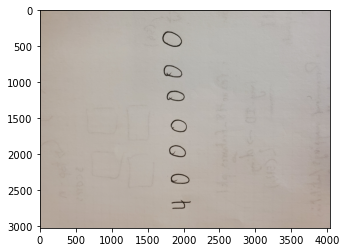

In [2]:
import matplotlib.image as mpimg

img = mpimg.imread('Test_Numbers_2.jpg')

fig, ax = plt.subplots()
ax.imshow(img);

In [5]:
def floodfill(img, low_cutoff = 0, high_cutoff = 255):
    dx = np.array([1,1,1,0,0,-1,-1,-1])
    dy = np.array([1,0,-1,1,-1,1,0,-1])
    #img should be a np array
    (nrows, ncols) = img.shape
    binary_img = np.zeros(img.shape)
    visited_array = np.zeros(img.shape, dtype = "bool")
    for row in range(nrows):
        for col in range(ncols):
            if (img[row,col] >= low_cutoff and img[row,col] <= high_cutoff):
                binary_img[row,col] = 1
    
    bounds = []
    for col in range(ncols):
        for row in range(nrows):
            if (binary_img[row,col] == 0 or visited_array[row,col] == True):
                continue
            maxrow = -1
            maxcol = -1
            minrow = 1000000000
            mincol = 1000000000
            visited_array[row,col] = True
            q = Queue()
            q.put((row,col))
            while (q.qsize() != 0):
                cur_loc = q.get()
                maxrow = max(maxrow, cur_loc[0])
                maxcol = max(maxcol, cur_loc[1])
                minrow = min(minrow, cur_loc[0])
                mincol = min(mincol, cur_loc[1])
                for index in range(8):
                    newx = dx[index] + cur_loc[0]
                    newy = dy[index] + cur_loc[1]
                    if (newx >= 0 and newx < nrows and newy >= 0 and newy < ncols and visited_array[newx, newy] == False and binary_img[newx, newy] == 1):
                        visited_array[newx, newy] = True
                        q.put((newx, newy))
            bounds.append([minrow, maxrow, mincol, maxcol])
    return bounds

In [6]:
def rgb_to_grayscale(rgb_img):
    img = np.einsum("...hwc,c->...hw", rgb_img, [0.2989, 0.5870, 0.1140])
    return img

In [7]:
def detect_digits(img_path):
    img = plt.imread(img_path)
    # print(img.shape)
    new_img = rgb_to_grayscale(img)
    new_img = new_img.T[...,::-1]
    (nrows, ncols) = new_img.shape
    if (nrows > 500):
        new_img = cv2.resize(new_img, (500, nrows))
    (nrow, ncols) = new_img.shape
    if (nrows > 500):
        new_img = cv2.resize(new_img, (ncols, 500))
    plt.imshow(new_img, cmap = "gray")
    subimages = floodfill(new_img, high_cutoff=100)
    for subimage in subimages:
        #print(subimage)
        subimage[0] -= 16
        subimage[1] += 16
        subimage[2] -= 16
        subimage[3] += 16
    answers = []
    for subimage in subimages:
        answers.append(new_img[subimage[0]:subimage[1],subimage[2]:subimage[3]])
    return answers

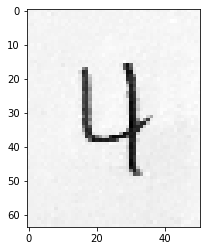

In [8]:
#plt.imshow(new_img, cmap = "gray")
answers = detect_digits("Test_Numbers_2.jpg")
plt.imshow(answers[0], cmap = "gray")


In [3]:
class Model:
    ''' A simple convolutional neural network. '''
    def __init__(self, num_input_channels, f1, f2, d1, num_classes):
        """
        Parameters
        ----------
        num_input_channels : int
            The number of channels for a input datum
            
        f1 : int
            The number of filters in conv-layer 1
        
        f2 : int
            The number of filters in conv-layer 2

        d1 : int
            The number of neurons in dense-layer 1
        
        num_classes : int
            The number of classes predicted by the model.
        """
        # Initialize your two convolution layers and two dense layers each 
        # as class attributes using the functions imported from MyNN
        #
        # We will use `weight_initializer=glorot_uniform` for all 4 layers
        
        # Note that you will need to compute `input_size` for
        # dense layer 1 : the number of elements being produced by the preceding conv
        # layer
        init_kwargs = {'gain': np.sqrt(2)}
        self.conv1 = conv(num_input_channels, f1, 5, 5, 
                          weight_initializer=glorot_uniform, 
                          weight_kwargs=init_kwargs)
        self.conv2 = conv(f1, f2, 5, 5 ,
                          weight_initializer=glorot_uniform, 
                          weight_kwargs=init_kwargs)
        self.dense1 = dense(f2 * 5 * 5, d1, 
                            weight_initializer=glorot_uniform, 
                            weight_kwargs=init_kwargs)
        self.dense2 = dense(d1, num_classes, 
                            weight_initializer=glorot_uniform, 
                            weight_kwargs=init_kwargs)


    def __call__(self, x):
        ''' Defines a forward pass of the model.
        
        Parameters
        ----------
        x : numpy.ndarray, shape=(N, 1, 32, 32)
            The input data, where N is the number of images.
            
        Returns
        -------
        mygrad.Tensor, shape=(N, num_classes)
            The class scores for each of the N images.
        '''
        
        # Define the "forward pass" for this model based on the architecture detailed above.
        # Note that, to compute 
        # We know the new dimension given the formula: out_size = ((in_size - filter_size)/stride) + 1
        x = relu(self.conv1(x))
        x = max_pool(x, (2, 2), 2)
        x = relu(self.conv2(x))
        x = max_pool(x, (2, 2), 2)
        x = relu(self.dense1(x.reshape(x.shape[0], -1)))
        return self.dense2(x)
    
    def load_model(self, path):
        with open(path, "rb") as f:
            for param, (name, array) in zip(self.parameters, np.load(f).items()):
                param.data[:] = array

    @property
    def parameters(self):
        """ A convenience function for getting all the parameters of our model. """
        # Create a list of every parameter contained in the 4 layers you wrote in your __init__ function
        params = []
        for layer in (self.conv1, self.conv2, self.dense1, self.dense2):
            params += list(layer.parameters)
        return params

In [4]:
model = Model(f1=20, f2=10, d1=20, num_input_channels=1, num_classes=10)
model.load_model("handwrite_digit_model.pkl")

In [9]:
def convert_image(imgs):
    """
    Parameters
            ----------
            imgs : list of arrays
                List of arrays of bounded images of digits from detect_digits


    Output
            ----------
            new_imgs : np.array
                The (N, 1, 32, 32) of images to go into the model

    """
    N = len(imgs)
    convert_imgs = np.empty((N, 1, 32, 32))
    for i, j in enumerate(imgs):
        #change to 32 x 32
        img = cv2.resize(j, (32,32))
        #add the 1 at the beginning
        img = img[np.newaxis]
        convert_imgs[i] = img
    
    #typecast to float32
    convert_imgs = convert_imgs.astype(np.float32)
    convert_imgs = 255 - convert_imgs
    #normalize all data
    convert_imgs /=  255.
    return convert_imgs

In [10]:
def recog_digits(model, answers):
    p = convert_image(answers)
    new_p = model(p).data
    ID = [np.argmax(row) for row in new_p]
    return ID

In [11]:
def master_function(img):
    boxes = detect_digits(img)
    return recog_digits(model, boxes)

[4, 0, 0, 0, 0, 0, 0]


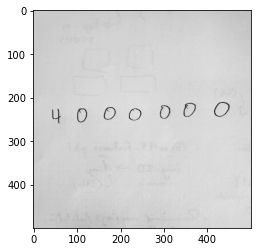

In [12]:
#Run this to actually comprehend handwritten digits
print(master_function("Test_Numbers_2.jpg"))